# [모듈 1.1] 데이터세트 다운로드 및 결합(1/4부)
**다운로드** | 구조 | 전처리 | 기차 모델

**참고**: 이 노트북은 ml.t3.xlarge 인스턴스에서 실행하는 것이 가장 좋습니다. 데이터 세트를 다운로드하는 동안 네트워크 오류가 발생하거나 메모리 부족 오류가 발생하면 사용 중인 인스턴스 크기를 늘려야 할 수 있습니다.

## COCO 및 CIFAR 데이터 세트
___
- 이 노트북은 두 가지 유형의 데이터 세트로 작업하는 방법을 배울겁니다.
    - 이 노트북 시리즈의 경우 [COCO 데이터 세트](https://cocodataset.org) 및 [CIFAR-10 데이터 세트](https://www.cs.toronto.edu/~kriz/cifar.html)에서 이미지를 샘플링합니다. 이 시리즈의 노트북을 시작하기 전에 각 데이터 세트 웹사이트를 탐색하여 데이터에 익숙해지는 것이 좋습니다. 
- 둘 다 이미지 데이터 세트이지만 형식이 매우 다릅니다. 
    - COCO 데이터 세트
        - 딥 러닝을 위해 특별히 형식이 지정되거나 크기가 조정되지 않은 Flickr의 이미지가 포함되어 있습니다.
        - <font color="red">즉 딥 러닝을 위해서 어떠한 사전 작업이 되어 있지 않습니다. 이 노트북에서 딥 러닝을 위해 원본 이미지의 처리 작업을 배웁니다.</font>
    - CIFAR-10 데이터 세트
        - <font color="red">반면에 CIFAR-10 이미지는 자르기, 크기 조정 및 벡터화 등의 딥 러닝을 위해 특별히 사전 처리가 되어 있습니다.</font>

<table align="left">
  <tr>
    <td>COCO Dataset
    </td>
    <td>Cifar-10 Dataset
    </td>
  </tr>    
  <tr>
    <td>
      <img src="img/coco.png" style="float:left; width:300px; height:150px;">
    </td>
    <td>
      <img src="img/cifar-10.png" style="float:left; width:300px; height:150px;">
    </td>      
  </tr>
</table>  


# 노트북 요약
---

실제 현업에서 이미지 데이터를 전처리하는 상황을 시뮬레이셔 하기 위해서 아래와 같은 작업을 수행 합니다.
- COCO 데이터 세트 매니페스트(manifest 파일)를 사용하여 10개 동물 카테고리 대한 이미지만을 다운로드합니다. (10개의 동물 카테고리)
- 그런 다음 CIFAR 데이터 세트에서 개구리 이미지를 다운로드하여 COCO 동물 이미지에 추가합니다. (총 11개의 동물 카테고리)
- 결론적으로 필요한 이미지를 로컬에 다운로드 받고, 주석 정보 (이미지 파일 경로 및 레이블 등)를 생성 합니다.



## Overview

1. COCO 데이터 세트의 주석 (annotations) 을 다운로드 및 확인
2. 전체 주석에서 "동물" 주석만 추출
3. 레이블 및 파일 경로 정보 결합
4. 데이터세트 샘플링
5. 이미지 파일을 병렬로 다운로드 (약 2분 소요)
6. CIFAR-10 개구리 데이터와 결합
7. 개구리 주석을 기존의 coco 2500개의  주석 (`sample_annos`) 에 추가
8. 최종 주석을 피클 파일로 저장

<pre>
</pre>

# 0. 환경 설정

In [1]:
import json
import pickle
import shutil
import urllib
import pathlib
import tarfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from imageio import imread, imwrite

파이썬 라이브러리를 로딩시에 재로딩을 하는 코드 입니다.

In [2]:
%load_ext autoreload
%autoreload 2


# 1. COCO 데이터 세트의 주석 (annotations) 을 다운로드 및 확인
____
- 데이터세트 주석 파일에는 클래스, 슈퍼클래스, 파일 이름 및 파일을 다운로드할 URL과 같은 이미지에 대한 정보가 포함되어 있습니다. 
- 참고로 COCO 데이터 세트에 대한 주석만 약 242MB입니다.

주석을 다운로드 받고, 압축을 해제 합니다.

In [3]:
anno_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
urllib.request.urlretrieve(anno_url, "coco-annotations.zip");

In [4]:
shutil.unpack_archive("coco-annotations.zip")

## 주석 (annotations) Json 을 로딩

훈련 및 검증 주석은 Json 형식으로 되어 있습니다. 파일을 각각 로딩 하겠습니다. 

In [5]:
with open("annotations/instances_train2017.json", "r") as f:
    train_metadata = json.load(f)

with open("annotations/instances_val2017.json", "r") as f:
    val_metadata = json.load(f)

## 이미지 파일의 주석에 대한 내용 확인
- 아미지 ID 및 원본 이미지 경로 및 coco 경로가 있습니다.

In [6]:
train_metadata['images'][0:2]

[{'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 {'license': 4,
  'file_name': '000000522418.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 11:38:44',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'id': 522418}]

전체 훈련 및 검증에 대한 이미지의 갯수


In [7]:
print("# of images in train_metadata: " , len(train_metadata['images']))
print("# of images in val_metadata: " , len(val_metadata['images']))

# of images in train_metadata:  118287
# of images in val_metadata:  5000


## 주석 레이블 종류
- 주석 레이블에는 Segmentation, 바운딩박스, Category ID, Image_id 의 정보가 있습니다.
    - 우리는 `이미지 분류` 작업을 위해서 Category ID 를 이용할 겁니다.

In [8]:
for a in train_metadata['annotations']:
    print(a)
    break

{'segmentation': [[239.97, 260.24, 222.04, 270.49, 199.84, 253.41, 213.5, 227.79, 259.62, 200.46, 274.13, 202.17, 277.55, 210.71, 249.37, 253.41, 237.41, 264.51, 242.54, 261.95, 228.87, 271.34]], 'area': 2765.1486500000005, 'iscrowd': 0, 'image_id': 558840, 'bbox': [199.84, 200.46, 77.71, 70.88], 'category_id': 58, 'id': 156}


## 전체 이미지의 카테고리 확인
카테고리 구조를 파악할 수 있습니다.

In [9]:
train_metadata["categories"][0:25]

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

전체 카테고리의 개수를 확인 합니다.

In [10]:
print("# of Categories: " , len(train_metadata["categories"]))

# of Categories:  80



# 2. 전체 카테고리 주석에서 "동물" 만 추출
___
이 가이드의 데이터 세트 범위를 제한하기 위해 COCO 데이터 세트의 동물 이미지만 사용합니다.

In [11]:
category_labels = {
    c["id"]: c["name"] for c in train_metadata["categories"] if c["supercategory"] == "animal"
}

In [12]:
category_labels

{16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe'}

## 레이블 추출 (이미지 ID 와 카테고리 ID 추출)

```
<Image ID> {category_id: <ID>} 형식으로 추출 합니다.
예: 495357 {'category_id': 18}
```


In [13]:
train_annos = {}
for a in train_metadata["annotations"]:
    if a["category_id"] in category_labels:
        train_annos[a["image_id"]] = {"category_id": a["category_id"]}


from src.m_utils import show_dic_items     
            
show_dic_items(train_annos)      
# print(len(train_annos))

495357 {'category_id': 18}
116061 {'category_id': 18}
16164 {'category_id': 18}


## 이미지 정보 추출 (이미지 ID, 이미지 URL, 파일 이름 추출)

```
<Image ID> {'coco_url': <URL>, 'file_name': <File Name} 으로 추출 합니다.

예: 391895 {'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'file_name': '000000391895.jpg'}
```
- 훈련 및 검증 데이터 세트에 반복 합니다.

In [14]:
train_images = {}
for i in train_metadata["images"]:
    train_images[i["id"]] = {"coco_url": i["coco_url"], "file_name": i["file_name"]}

print(show_dic_items(train_images))     

391895 {'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg', 'file_name': '000000391895.jpg'}
522418 {'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg', 'file_name': '000000522418.jpg'}
184613 {'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg', 'file_name': '000000184613.jpg'}
None


In [15]:
val_annos = {}
for a in val_metadata["annotations"]:
    if a["category_id"] in category_labels:
        val_annos[a["image_id"]] = {"category_id": a["category_id"]}

val_images = {}
for i in val_metadata["images"]:
    val_images[i["id"]] = {"coco_url": i["coco_url"], "file_name": i["file_name"]}

# 3. 레이블 및 이미지 파일 경로 정보 결합

- 레이블 및 이미지 파일 경로를 결합하여 이미지의 모든 주석 정보를 만듭니다.

아래와 같이 기존의 이미지 ID, 카테고리 ID에 추가적으로 이미지 경로를 추가 합니다.
```
495357 {'category_id': 18}
--> 
495357 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000495357.jpg', 'file_name': '000000495357.jpg'}
```

이미지의 레이블 정보 확인 합니다.

In [16]:
show_dic_items(train_annos)

495357 {'category_id': 18}
116061 {'category_id': 18}
16164 {'category_id': 18}


이미지의 레이블 정보와 파일 경로를 결합 합니다.

In [17]:
for id, anno in train_annos.items():
    anno.update(train_images[id])

for id, anno in val_annos.items():
    anno.update(val_images[id])

결합한 내용 확인하기

In [18]:
show_dic_items(train_annos)

495357 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000495357.jpg', 'file_name': '000000495357.jpg'}
116061 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000116061.jpg', 'file_name': '000000116061.jpg'}
16164 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000016164.jpg', 'file_name': '000000016164.jpg'}


## 훈련과 검증 데이터 세트를 결합
- 현재의 훈련과 검증 데이터 세트의 2 분할을 3분할인 훈련, 검증, 테스트 데이터 세트로 만들기 위해 일단 합칩니다.

In [19]:
all_annos = {}
for k, v in train_annos.items():
    all_annos.update({k: v})
for k, v in val_annos.items():
    all_annos.update({k: v})

In [20]:
print(show_dic_items(all_annos))     

495357 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000495357.jpg', 'file_name': '000000495357.jpg'}
116061 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000116061.jpg', 'file_name': '000000116061.jpg'}
16164 {'category_id': 18, 'coco_url': 'http://images.cocodataset.org/train2017/000000016164.jpg', 'file_name': '000000016164.jpg'}
None


# 4. 데이터세트 샘플링
___
- 데이터 작업을 더 쉽게 하기 위해 각 카테고리에서 무작위로 250개의 이미지를 선택합니다. 
    - 카테고리 당 250개. 10개의 카테고리여서 최종 2500 개가 됩니다.
    - 이것은 데이터 세트의 작은 부분이지만 전이 학습(Transfer Learning)을 사용하기에는 적당한 사이즈 입니다. 
- 이를 실행할 때마다 동일한 이미지 세트를 얻을 수 있도록 Numpy의 랜덤 시드로 0을 설정합니다.


In [21]:
np.random.seed(0)

In [22]:
sample_annos = {} # 샘플링을 한 주석 정보를 담을 변수를 선언 합니다.

for category_id in category_labels:
    subset = [k for k, v in all_annos.items() if v["category_id"] == category_id]
    sample = np.random.choice(subset, size=250, replace=False)
    for k in sample:
        sample_annos[k] = all_annos[k]

In [23]:
print(show_dic_items(sample_annos))     
print(len(sample_annos))     

442968 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000442968.jpg', 'file_name': '000000442968.jpg'}
121193 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000121193.jpg', 'file_name': '000000121193.jpg'}
192160 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000192160.jpg', 'file_name': '000000192160.jpg'}
None
2500


# 5. 이미지 URL을 통해 이미지를 병렬로 다운로드 (약 2분 소요)
- 다중 스레딩을 위한 함수 정의
- 이미지 저장 폴더 생성
- 이미지 다운로드를 병렬화화를 위한 Worker Thread 개수 정의
    - 예시로 20을 설정할 수 있고, 에러 발생시에 수치를 낮추시기 바랍니다.
- joblib로 다중 스레딩을 위한 함수 실행

In [24]:
def download_image(url, path):
    data = imread(url)
    imwrite(path / url.split("/")[-1], data)

In [25]:
sample_dir = pathlib.Path("data_sample_2500")
sample_dir.mkdir(exist_ok=True)
num_workers = 20 # 에러 발생시 줄이세요.

In [26]:
%%time
from joblib import Parallel, delayed, parallel_backend

with parallel_backend("threading", n_jobs=num_workers):
    Parallel(verbose=3)(
        delayed(download_image)(a["coco_url"], sample_dir) for a in sample_annos.values()
    )

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=20)]: Done 248 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done 472 tasks      | elapsed:   22.1s
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:   35.7s
[Parallel(n_jobs=20)]: Done 1112 tasks      | elapsed:   53.4s
[Parallel(n_jobs=20)]: Done 1528 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 2008 tasks      | elapsed:  1.7min


CPU times: user 52.3 s, sys: 3.3 s, total: 55.6 s
Wall time: 2min 3s


[Parallel(n_jobs=20)]: Done 2500 out of 2500 | elapsed:  2.1min finished


<pre>
</pre>

# 6. CIFAR-10 개구리 데이터와 결합
___
- COCO 데이터 세트에는 개구리 이미지가 포함되어 있지 않지만 모델이 개구리 이미지에 레이블을 지정할 수도 있어야 한다고 가정해 보겠습니다. 
- 이 문제를 해결하기 위해 개구리가 포함된 다른 이미지 데이터 세트를 다운로드하고 250개의 개구리 이미지를 샘플링하여 기존 이미지 데이터에 추가할 수 있습니다. 
- CIFAR-10 이미지는 훨씬 작기 때문에(32x32) 크기를 (244x244)로 늘리면 픽셀화되고 흐릿하게 나타납니다. 
- CIFAR-10 데이터 세트는 COCO 데이터 세트와 매우 다른 방식으로 형식이 지정됩니다. COCO 이미지와 일치하도록 CIFAR-10 데이터를 개별 이미지 파일로 처리 합니다.

## CIFAR-10 dataset 다운로드 및 추출

In [29]:
!wget --no-check-certificate https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!wget https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz

--2021-12-25 14:47:43--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.2’

cifar-10-python.tar 100%[===================>] 162.60M  15.9MB/s    in 12s     

2021-12-25 14:47:55 (13.8 MB/s) - ‘cifar-10-python.tar.gz.2’ saved [170498071/170498071]



In [30]:
tf = tarfile.open("cifar-10-python.tar.gz")
tf.extractall()

## CIFAR-10 데이터 세트의 첫 번째 배치 열기
- CIFAR-10 데이터 세트는 5개의 훈련 배치와 1개의 테스트 배치로 제공됩니다. 
- 각 훈련 배치에는 10,000개의 무작위로 정렬된 이미지가 있습니다. 데이터 세트에 250개의 개구리 이미지만 필요하므로 첫 번째 배치에서만 가져옵니다.

In [31]:
with open("./cifar-10-batches-py/data_batch_1", "rb") as f:
    batch_1 = pickle.load(f, encoding="bytes")

In [32]:
image_data = batch_1[b"data"]

#### 이미지 정보
- 10000개의 이미지가 존재하고, 가로(32) X 세로(32) X 채널(3) = 3,072 의 픽셀 데이타가 존재 합니다.

In [33]:
print("\nImage Shape: ", image_data.shape, "\n")
print(image_data)



Image Shape:  (10000, 3072) 

[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [ 71  60  74 ...  68  69  68]
 [250 254 211 ... 215 255 254]
 [ 62  61  60 ... 130 130 131]]


## 250 개구리 이미지 샘플링
- 개구리의 레이블 "6" 인 개구리 인덱스 추출
- 랜덤하게 250개의 인덱스 추출
- 250개의 인덱스에 해당되는 이미지 데이터 추출
- 개구리 이미지 데이터를 [250, 32, 32, 3] 으로 재구성

In [34]:
frog_indices = np.array(batch_1[b"labels"]) == 6 # 6 == 개구리
sample_frog_indices = np.random.choice(frog_indices.nonzero()[0], size=250, replace=False) # 랜덤으로 250개 개구리 인텍스 추출
sample_data = image_data[sample_frog_indices, :]
frog_images = sample_data.reshape(len(sample_data), 3, 32, 32).transpose(0, 2, 3, 1) # [250, 32, 32, 3] 으로 재구성
frog_images.shape

(250, 32, 32, 3)

### 개구리 이미지 보기

250 개의 이미지에서 랜덤으로 개구리 이미지를 확인 합니다.

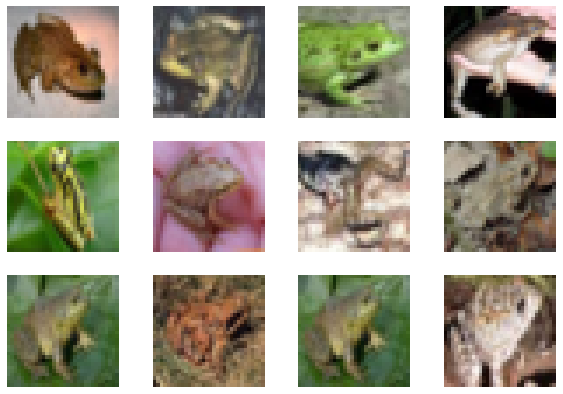

In [35]:
fig, axs = plt.subplots(3, 4, figsize=(10, 7))
indices = np.random.randint(low=0, high=249, size=12)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(frog_images[indices[i]])
    ax.axis("off")

## 개구리 이미지를 추가 하여 data_sample_2750 생성
- 개구리 인덱스에 대한 파일 이름을 추출
- 파일이름의 확장자를 png --> jpg 로 변경하고, 데이타를 추출하여 data_sample_2500 에 저장 함.
- data_sample_2500 폴더를 data_sample_2750 으로 변경

In [36]:
frog_filenames = np.array(batch_1[b"filenames"])[sample_frog_indices]
frog_filenames[0:3]

array([b'leptodactylid_s_000084.png', b'alytes_obstetricans_s_000124.png',
       b'spadefoot_s_000247.png'], dtype='|S40')

In [37]:
for idx, filename in enumerate(frog_filenames):
    filename = filename.decode()
    data = frog_images[idx]
    if filename.endswith(".png"):
        filename = filename.replace(".png", ".jpg")
    imwrite(sample_dir / filename, data)

In [38]:
import os
import shutil
new_folder_name = "data_sample_2750"

if os.path.isdir(new_folder_name): # 폴더가 존재하면 먼저 삭제 함.
    shutil.rmtree(new_folder_name)
    print(f"{new_folder_name} is deleted")
    
sample_dir.rename(new_folder_name)
print(f"{sample_dir} is renamed to {new_folder_name}")

data_sample_2500 is renamed to data_sample_2750


# 7. 개구리 주석을 기존의 coco 2500개의  주석 (`sample_annos`) 에 추가

기존 category_labels 에 26 번으로서 frog 를 추가

In [39]:
category_labels[26] = "frog"

In [40]:
# 기존의 coco 2500 개에 해당하는 이미지 ID의 다음 값 부터 이후 값 추출 (Next_ID)
next_anno_idx = np.array(list(sample_annos.keys())).max() + 1
# Next_ID 부터 250개의 이미지 ID를 생성
frog_anno_ids = range(next_anno_idx, next_anno_idx + len(frog_images))

기존의 2500개에서 개구리 250개를 카테고리 ID, 파일 이름을 추가 함.

In [41]:
for idx, frog_id in enumerate(frog_anno_ids):
    sample_annos[frog_id] = {
        "category_id": 26,
        "file_name": frog_filenames[idx].decode().replace(".png", ".jpg"),
    }

# 8. 최종 주석을 피클 파일로 저장
___
- 이것은 이미지 데이터로 딥 러닝 모델을 훈련하기 위한 일련의 가이드 중 첫 번째일 뿐입니다. 
- 작업이 후속 노트북으로 넘어가도록 하기 위해 아래 두개의 피클 파일을 생성 합니다.
    - 데이터세트 주석
    - 카테고리 이름

In [44]:
print(show_dic_items(sample_annos))     

442968 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000442968.jpg', 'file_name': '000000442968.jpg'}
121193 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000121193.jpg', 'file_name': '000000121193.jpg'}
192160 {'category_id': 16, 'coco_url': 'http://images.cocodataset.org/train2017/000000192160.jpg', 'file_name': '000000192160.jpg'}
None


In [45]:
print(show_dic_items(category_labels,11))     

16 bird
17 cat
18 dog
19 horse
20 sheep
21 cow
22 elephant
23 bear
24 zebra
25 giraffe
26 frog
None


In [46]:
pickled_dir = pathlib.Path("./pickled_data")
pickled_dir.mkdir(exist_ok=True)

with open("pickled_data/sample_annos.pickle", "wb") as f:
    pickle.dump(sample_annos, f)

with open("./pickled_data/category_labels.pickle", "wb") as f:
    pickle.dump(category_labels, f)